## XGBoost Model Commodities Trading - Quant Sector - Brandon Michaels
#### XGBoost using oil commodity futures to forecast price movements on oil market

Needed to install dependencies

In [126]:
!pip install pandas numpy xgboost requests fredapi pandas_ta -q
!pip install optuna
!pip install ipywidgets
!pip install yfinance
!pip install imblearn

In [127]:
import pandas as pd
import numpy as np
import xgboost as xgb
#import pandas_ta as ta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from scipy.fftpack import fft
import requests
from fredapi import Fred
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from IPython import get_ipython
from imblearn.over_sampling import SMOTE
import yfinance as yf
from sklearn.decomposition import PCA
from scipy import signal
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

Fetch Oil Commodity Data from CME & EIA

In [128]:
def fetch_cme_oil_data():
    url = "https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/5278/G"
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['quotes'])

def fetch_eia_oil_data(api_key):
    url = f"https://api.eia.gov/v2/crude-oil-imports/data/?api_key={api_key}&frequency=monthly&data[0]=quantity&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"

    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

    data = response.json()

    if 'response' not in data or 'data' not in data['response']:
        raise KeyError("Unexpected response structure. Check API key and endpoint.")

    df = pd.DataFrame(data['response']['data'])
    return df

def fetch_metal_data():
    metals = yf.download(["GC=F", "SI=F"], period="5y", interval="1d")
    metals = metals["Close"].reset_index()
    metals = metals.melt(id_vars=["Date"], var_name="Ticker", value_name="Price")
    metals.dropna(inplace=True)
    return metals

### Fetch Macroeconomic Indicators from FRED (Lagged Indicators: RSI, MACD, ACD)

In [129]:
def fetch_fred_data(api_key, series_ids):
    fred = Fred(api_key)
    data = {}
    for series_id in series_ids:
        data[series_id] = fred.get_series(series_id)
    return pd.DataFrame(data)

Converting Time Series to Stationary

In [130]:
def make_stationary(df, column='Price'):
    """
    Advanced stationarity transformation with multiple techniques

    Parameters:
    - df: Input DataFrame
    - column: Column to transform

    Returns:
    - DataFrame with stationarity features
    """
    # Log transformation to stabilize variance
    df['Log_Price'] = np.log(df[column])

    # First-order differencing
    df['First_Diff'] = df['Log_Price'].diff()

    # Percent change
    df['Pct_Change'] = df[column].pct_change()

    # Exponential weighted moving average (EWMA)
    df['EWMA_10'] = df[column].ewm(span=10).mean()
    df['EWMA_Diff'] = df[column] - df['EWMA_10']

    # Rolling (past only z-score)
    rolling_mean = df[column].rolling(252, min_periods=60).mean()
    rolling_std  = df[column].rolling(252, min_periods=60).std()
    df['Z_Score'] = (df[column] - rolling_mean) / rolling_std

    return df.dropna()

#### Use Phase Angles to determine timing within period

In [131]:
def add_phase_angles(df, column='Price', sampling_rate=1):
    """
    Advanced phase angle computation with adaptive frequency detection

    Parameters:
    - df: Input DataFrame
    - column: Column to analyze
    - sampling_rate: Sampling rate for frequency computation

    Returns:
    - DataFrame with phase angle features
    """
    # Compute Hilbert-Huang Transform for adaptive frequency analysis
    def hilbert_huang_transform(data):
        # Empirical Mode Decomposition
        def find_extrema(x):
            maxima = signal.argrelextrema(x, np.greater)[0]
            minima = signal.argrelextrema(x, np.less)[0]
            return maxima, minima

        # Sift process (simplified)
        def sift(x):
            maxima, minima = find_extrema(x)
            upper_envelope = np.interp(np.arange(len(x)), maxima, x[maxima])
            lower_envelope = np.interp(np.arange(len(x)), minima, x[minima])
            mean_envelope = (upper_envelope + lower_envelope) / 2
            return x - mean_envelope

        # Decompose
        imf = sift(data)
        return imf

    # Extract signal
    signal_data = df[column].values

    # Apply Hilbert-Huang Transform
    # imf = hilbert_huang_transform(signal_data)

    # Compute Fourier Transform
    fft_values = np.fft.fft(signal_data)
    freqs = np.fft.fftfreq(len(signal_data), d=sampling_rate)

    # Dominant frequencies
    dominant_freq_index = np.argmax(np.abs(fft_values[1:len(fft_values)//2])) + 1
    dominant_freq = freqs[dominant_freq_index]

    # Phase angles
    angles = np.angle(fft_values)

    # Create features
    df['Dominant_Frequency'] = dominant_freq
    df['Phase_Angle'] = angles[dominant_freq_index]

    # Cycle classification based on phase
    df['Cycle_Phase'] = pd.cut(angles,
                                bins=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                                labels=['Contraction', 'Early Growth', 'Expansion', 'Late Growth'])

    return df

### Fourier Features

Rolling Window

In [132]:
def add_fourier_features(df, column='Price', max_components=10):
    """
    Advanced Fourier feature extraction with adaptive component selection

    Parameters:
    - df: Input DataFrame
    - column: Column to analyze
    - max_components: Maximum Fourier components to extract

    Returns:
    - DataFrame with Fourier features
    """
    # Extract signal
    signal_data = df[column].values

    # Compute Fast Fourier Transform
    fft_values = np.fft.fft(signal_data)
    frequencies = np.fft.fftfreq(len(signal_data))

    # Compute power spectrum
    power_spectrum = np.abs(fft_values)**2

    # Select top components based on power
    top_component_indices = np.argsort(power_spectrum[1:len(signal_data)//2])[-max_components:]

    # Extract top frequency components
    for idx in top_component_indices:
        # Cosine and sine representations
        df[f'Fourier_Cos_{idx}'] = np.cos(2 * np.pi * frequencies[idx] * np.arange(len(signal_data)))
        df[f'Fourier_Sin_{idx}'] = np.sin(2 * np.pi * frequencies[idx] * np.arange(len(signal_data)))

    # Additional spectral features
    df['Spectral_Centroid'] = np.sum(frequencies[1:len(signal_data)//2] * power_spectrum[1:len(signal_data)//2]) / np.sum(power_spectrum[1:len(signal_data)//2])
    # Change here to make Spectral_Centroid a scalar before broadcasting
    spectral_centroid_scalar = df['Spectral_Centroid'].iloc[0]
    df['Spectral_Spread'] = np.sqrt(np.sum(((frequencies[1:len(signal_data)//2] - spectral_centroid_scalar)**2 * power_spectrum[1:len(signal_data)//2]) / np.sum(power_spectrum[1:len(signal_data)//2])))

    return df.dropna()

### Lagged Features
##### Add lagged price features to capture momentum. #####

In [133]:
def add_lagged_features(df, column='Price', optimal_lags=[50, 125]):
    """
    Create lagged features with predefined optimal lags for Gold and Silver

    Parameters:
    - df: Input DataFrame
    - column: Column to create lags for
    - optimal_lags: Predefined optimal lag periods

    Returns:
    - DataFrame with lagged features
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Create lagged features for each predefined lag
    for lag in optimal_lags:
        # Absolute price lagged features
        df[f'Lag_{lag}'] = df.groupby('Ticker')[column].shift(lag)

        # Percentage change lagged features
        df[f'Pct_Change_{lag}'] = df.groupby('Ticker')[column].pct_change(lag)

        # Momentum indicator (price relative to lagged price)
        df[f'Momentum_{lag}'] = (df[column] - df[f'Lag_{lag}']) / df[f'Lag_{lag}']

    # Compute additional derived features
    # Relative strength between current price and lagged prices
    df['RS_50_125'] = (df[f'Lag_50'] - df[f'Lag_125']) / df[f'Lag_125']

    # Volatility between different lag periods - **CHANGE HERE**
    # Reset index before assignment to match original DataFrame's index
    df['Volatility_50_125'] = (df.groupby('Ticker')[column].rolling(window=125).std() / \
                               df.groupby('Ticker')[column].rolling(window=50).std()).reset_index(level=0, drop=True)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    return df

### Lagged Feature Validation

In [134]:
def validate_lagged_features(df):
    """
    Validate the effectiveness of lagged features

    Parameters:
    - df: DataFrame with lagged features

    Returns:
    - Correlation matrix and feature importance insights
    """

    # Select lagged feature columns
    lagged_cols = [col for col in df.columns if 'Lag_' in col or 'Pct_Change_' in col or 'Momentum_' in col]

    # Compute correlation matrix
    corr_matrix = df[lagged_cols + ['Trend']].corr()

    # Visualize correlation
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation of Lagged Features with Trend')
    plt.tight_layout()
    plt.show()

    # Print correlation with trend
    trend_correlations = corr_matrix['Trend'].sort_values(ascending=False)
    print("Top Correlated Lagged Features with Trend:")
    print(trend_correlations)

    return corr_matrix

### Feature Modeling

In [135]:
def feature_importance_analysis(X, y, model):
    """
    Analyze feature importance for lagged features

    Parameters:
    - X: Feature matrix
    - y: Target variable
    - model: Trained XGBoost model

    Returns:
    - Feature importance DataFrame
    """
    # Get feature importances
    feature_importance = model.feature_importances_

    # Create a DataFrame of feature importances
    feature_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importance
    })

    # Sort features by importance
    feature_imp = feature_imp.sort_values('importance', ascending=False)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_imp['feature'][:10], feature_imp['importance'][:10])
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return feature_imp

### Fast Fourier Transforms Analysis
##### Perform FFT to detect dominant price periodicities. #####

In [136]:
def apply_fft_analysis(df):
    close_prices = df['quantity'].dropna().values
    N = len(close_prices)
    fft_values = np.fft.fft(close_prices)
    freqs = np.fft.fftfreq(N)

    # Extract dominant frequency (ignoring zero frequency)
    dominant_freq = freqs[np.argmax(np.abs(fft_values[1:N//2]))]
    df['Dominant_Periodicity'] = abs(1/dominant_freq) if dominant_freq != 0 else np.nan
    return df

### Preprocessing and Feature Engineering

In [137]:
def preprocess_data(df):
    # Convert period to datetime
    df['period'] = pd.to_datetime(df['period'])
    df.set_index('period', inplace=True)

    # Quantity to int for calculations
    df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

    # Drop rows where quantity couldn't be converted
    df.dropna(subset=['quantity'], inplace=True)

    # Compute RSI, MACD
    df['Returns'] = df['quantity'].pct_change()
    df['RSI'] = ta.rsi(df['quantity'], length=14)
    df['MACD'] = ta.macd(df['quantity'])['MACD_12_26_9']

    # Bollinger Bands
    bbands = ta.bbands(df['quantity'], length=20)
    df['Bollinger_Upper'], df['Bollinger_Lower'] = bbands[['BBU_20_2.0', 'BBL_20_2.0']].T.values

    df.dropna(inplace=True)

    df['Trend'] = np.where(df['Returns'] > 0.005, 'Bullish',
                           np.where(df['Returns'] < -0.005, 'Bearish', 'Neutral'))

    df['Trend'] = df['Trend'].shift(-1)

    # Magnitude of movement
    df['Magnitude'] = abs(df['Returns'])

     # Add Lagged Features and FFT Analysis
    df = add_lagged_features(df)
    df = apply_fft_analysis(df)

    return df

In [138]:
def preprocess(df):
    # Ensure Date is converted to datetime if not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract numerical features from datetime
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Advanced feature engineering
    df['Rolling_Mean_10'] = df.groupby('Ticker')['Price'].rolling(window=10).mean().reset_index(level=0, drop=True)
    df['Rolling_Std_10'] = df.groupby('Ticker')['Price'].rolling(window=10).std().reset_index(level=0, drop=True)

    # Advanced returns and volatility
    df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
    df['Volatility'] = df.groupby('Ticker')['Log_Returns'].rolling(window=20).std().reset_index(level=0, drop=True)

    # More sophisticated trend detection
    def detect_trend(returns, volatility):
        if returns > 2 * volatility:
            return 2  # Strong Bullish
        elif returns < -2 * volatility:
            return 0  # Strong Bearish
        else:
            return 1  # Neutral

    df['Trend'] = df.apply(lambda row: detect_trend(row['Log_Returns'], row['Volatility']), axis=1)
    df['Trend'] = df['Trend'].shift(-1)

    # Drop NaNs more carefully
    df.dropna(subset=['Trend'], inplace=True)

    # Drop the original Date column as we've extracted its features
    df.drop(columns=['Date'], inplace=True)

    return df

### XGBoost Training

In [139]:
def train_model(df):
    features = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower']
    X = df[features]
    y = df['Trend']

    # Initialize LabelEncoder and fit_transform on y
    # Transforms y from ["Bearish", "Bullish", "Neutral"] to encoded [0, 1, 2]
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(y_train.value_counts())
    print(y_test.value_counts())

    # Inverse transform to get original labels for evaluation
    # i.e. ["Bearish", "Bullish", "Neutral"] for output
    y_pred = le.inverse_transform(y_pred)
    y_test = le.inverse_transform(y_test)

    y_pred_proba = model.predict_proba(X_test)

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

    # Confidence Interval for Oil Market
    for i, pred in enumerate(y_pred):
        print(f"Prediction: {pred}, Confidence Scores: {y_pred_proba[i]}")

    return model

In [140]:
def train_test_split_sequential(df, test_size=0.2):
    split_idx = int(len(df) * (1 - test_size))
    return df.iloc[:split_idx], df.iloc[split_idx:]

In [141]:
def train_models(df):
    # Drop any remaining non-numeric or non-categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'category']).columns
    df = df[numeric_cols]

    leak_cols = ['Trend', 'Returns', 'Log_Returns', 'Volatility']
    features = [col for col in df.columns if col not in leak_cols]
    X = df[features]
    y = LabelEncoder().fit_transform(df['Trend'])

    # Prevents overlap bleed between the end of train and start of test
    split_idx = int(len(df) * 0.8)
    embargo = 5  # trading days; adjust as needed
    train_df = df.iloc[:split_idx - embargo]
    test_df  = df.iloc[split_idx + embargo:]

    le = LabelEncoder()
    y_train = le.fit_transform(train_df['Trend'])
    y_test  = le.transform(test_df['Trend'])
    X_train = train_df.drop(columns=['Trend'])
    X_test  = test_df.drop(columns=['Trend'])

    # Convert categorical columns to numerical codes if any remain
    for col in X_train.select_dtypes(include=['category', 'object']).columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

    print(pd.Series(y_train).value_counts())
    print(pd.Series(y_test).value_counts())

    best_params = optimize_xgboost(X_train, y_train)

    model = xgb.XGBClassifier(
        **best_params,
        tree_method='hist',
        enable_categorical=True,
        eval_metric='mlogloss'
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_proba = model.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print("AUC Score:", auc_score)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

    # Train Accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Test Accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return model, X_train, X_test, y_train, y_test, X, y

#### Hyper-parameter Tuning

In [142]:
def optimize_xgboost(X_train, y_train):
    """Grid search for optimal XGBoost parameters."""

    # Convert 'Ticker' and 'Cycle_Phase' to numerical before optimization
    for col in ['Ticker', 'Cycle_Phase']:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype('category').cat.codes

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 100, 250),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 5)
        }
        class_weights = {0: 1, 1: 1, 2: len(y_train) / (2 * np.sum(y_train == 2))}

        from sklearn.model_selection import TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=3)
        val_scores = []
        for tr_idx, va_idx in tscv.split(X_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train[tr_idx], y_train[va_idx]
            model = xgb.XGBClassifier(
                **params,
                scale_pos_weight=class_weights,
                tree_method='hist',
                enable_categorical=True,
                eval_metric='mlogloss'
            )
            model.fit(X_tr, y_tr)
            val_scores.append(accuracy_score(y_va, model.predict(X_va)))
        return float(np.mean(val_scores))

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    return study.best_params

### SMOTE to prevent overfitting

In [143]:
def apply_smote(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

### Execution and Testing

In [144]:
def check_overfitting(model, X_train, X_test, y_train, y_test, X, y):
    # Training and test accuracy
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:")
    print(cm)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

In [145]:
def compare_sp500(model, X_test):
    # Fetch S&P 500 data
    sp500 = yf.download("^GSPC", period="1y")
    sp500_returns = sp500['Close'].pct_change().dropna()

    # Get model predictions
    xgboost_predictions = model.predict(X_test)

    # Trim predictions to match S&P 500 length
    if len(xgboost_predictions) > len(sp500_returns):
        xgboost_predictions = xgboost_predictions[:len(sp500_returns)]
    elif len(xgboost_predictions) < len(sp500_returns):
        sp500_returns = sp500_returns[:len(xgboost_predictions)]

    # Map predictions to returns
    xgboost_returns = pd.Series([0.005 if pred == 1 else -0.002 for pred in xgboost_predictions], index=sp500_returns.index)

    # Calculate cumulative returns
    xgboost_cumulative_returns = (1 + xgboost_returns).cumprod()
    sp500_cumulative_returns = (1 + sp500_returns).cumprod()

    # Plot comparison
    plt.figure(figsize=(10, 5))
    plt.plot(xgboost_cumulative_returns, label="XGBoost Strategy", linestyle="--", color="red")
    plt.plot(sp500_cumulative_returns, label="S&P 500", linestyle="-", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.title("XGBoost Strategy vs. S&P 500 Returns")
    plt.legend()
    plt.grid(True)
    plt.show()

### Cross-Validation

In [146]:
def time_series_cross_validation(model, X, y, n_splits=5):
    """
    Time series cross-validation with forward chaining

    Parameters:
    - model: ML model to validate
    - X: Features
    - y: Target
    - n_splits: Number of splits for cross-validation

    Returns:
    - Cross-validation scores
    """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cv_scores.append(accuracy_score(y_test, y_pred))

    return cv_scores

In [147]:
def apply_pca_and_filter_features(df, variance_threshold=0.95, correlation_threshold=0.85):
    """
    Applies PCA to visualize feature correlations and removes highly correlated features.

    Parameters:
        df (pd.DataFrame): DataFrame containing features.
        variance_threshold (float): Minimum cumulative explained variance to retain principal components.
        correlation_threshold (float): Threshold for dropping correlated features.

    Returns:
        pd.DataFrame: Reduced feature set.
    """
    # Drop non-numeric columns
    df_numeric = df.select_dtypes(include=[np.number])

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()

    # Component loadings
    loadings = pd.DataFrame(pca.components_, columns=df_numeric.columns)

    # Heatmap of feature contributions
    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings, cmap='coolwarm', annot=True)
    plt.title('Feature Contributions to Principal Components')
    plt.xlabel('Original Features')
    plt.ylabel('Principal Components')
    plt.show()

    # Select number of components that explain the required variance
    num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= variance_threshold) + 1
    reduced_features = df_numeric.columns[np.abs(loadings.iloc[:num_components]).max() < correlation_threshold]

    print(f"Reducing features from {df_numeric.shape[1]} to {len(reduced_features)} based on correlation threshold.")
    return df[reduced_features]

/tmp/ipython-input-2448978806.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  metals = yf.download(["GC=F", "SI=F"], period="5y", interval="1d")
[*********************100%***********************]  2 of 2 completed
[I 2025-09-05 14:10:30,005] A new study created in memory with name: no-name-10ab7d2f-9946-440b-a1d4-bc45c3607ead
/tmp/ipython-input-3131555892.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipython-input-3131555892.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 1.0),
/tmp/ipyt

           Date Ticker        Price
0    2020-09-08   GC=F  1933.000000
1    2020-09-09   GC=F  1944.699951
2    2020-09-10   GC=F  1954.199951
3    2020-09-11   GC=F  1937.800049
4    2020-09-14   GC=F  1953.099976
...         ...    ...          ...
2509 2025-08-29   SI=F    40.200001
2510 2025-09-02   SI=F    41.070999
2511 2025-09-03   SI=F    41.542000
2512 2025-09-04   SI=F    40.910999
2513 2025-09-05   SI=F    41.974998

[2514 rows x 3 columns]
1    1656
0      59
2      43
Name: count, dtype: int64
1    414
2     11
0     11
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-05 14:10:39,764] Trial 0 finished with value: 0.9430523917995443 and parameters: {'max_depth': 4, 'learning_rate': 0.01609927177734243, 'n_estimators': 205, 'subsample': 0.6068778979204724, 'colsample_bytree': 0.6423515721210392, 'reg_lambda': 0.20698326037006598, 'reg_alpha': 0.2693664386179491, 'min_child_weight':

AUC Score: 0.6509873672789275
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.95      1.00      0.97       414
           2       0.00      0.00      0.00        11

    accuracy                           0.95       436
   macro avg       0.32      0.33      0.32       436
weighted avg       0.90      0.95      0.92       436

Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


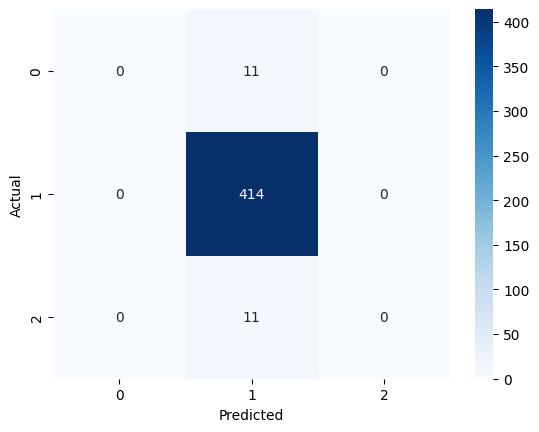

Accuracy Score: 0.9495412844036697
F1 Score: 0.924964921748516
Training Accuracy: 0.9420
Test Accuracy: 0.9495
Total Metal (Gold/Silver) Data:
     Ticker        Price  Year  Month  Day  DayOfWeek  Rolling_Mean_10  \
184    GC=F  1907.500000  2021      6    2          2      1893.240002   
185    GC=F  1871.199951  2021      6    3          3      1892.229993   
186    GC=F  1889.800049  2021      6    4          4      1893.029993   
187    GC=F  1896.800049  2021      6    7          0      1895.040002   
188    GC=F  1892.199951  2021      6    8          1      1895.800000   
...     ...          ...   ...    ...  ...        ...              ...   
2508   SI=F    39.189999  2025      8   28          3        38.297900   
2509   SI=F    40.200001  2025      8   29          4        38.528500   
2510   SI=F    41.070999  2025      9    2          1        38.840500   
2511   SI=F    41.542000  2025      9    3          2        39.268600   
2512   SI=F    40.910999  2025      9    4 

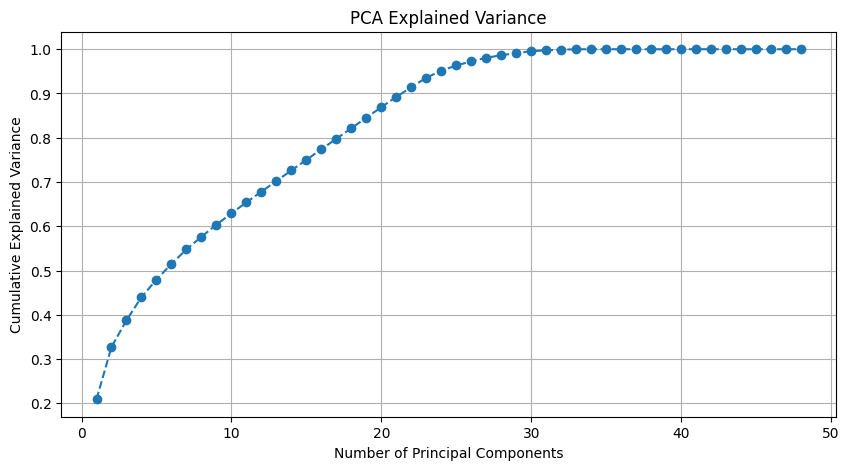

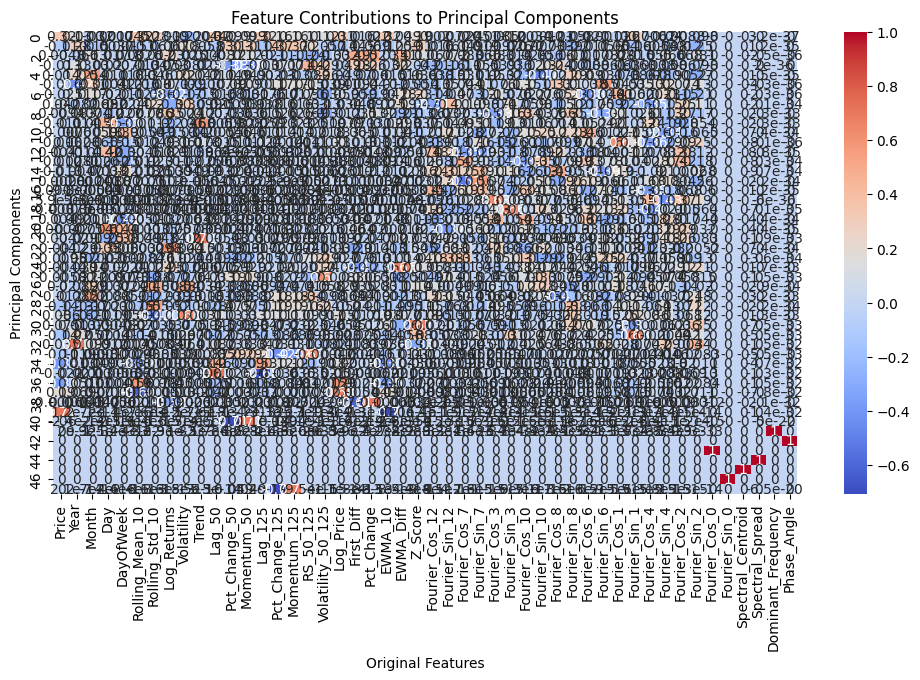

Reducing features from 48 to 48 based on correlation threshold.


In [148]:
eia_api_key = "atu9zCb0M2XSSJcIOPTwNDNpxbGo1T2SskDVGi9B"
fred_api_key = "013796f71d8f9436e978cd20885652fb"

# FED Data
macroeconomic_series = ['CPIAUCSL', 'UNRATE', 'GDP', 'FEDFUNDS']
# fred_data = fetch_fred_data(fred_api_key, macroeconomic_series)
# print(fred_data)

# EIA Oil Commodity Data
# eia_data = fetch_eia_oil_data(eia_api_key)
# print(eia_data)

metal_data = fetch_metal_data()
print(metal_data)

total_metal_data = preprocess(metal_data)
total_metal_data = add_lagged_features(total_metal_data)
total_metal_data = make_stationary(total_metal_data)
total_metal_data = add_fourier_features(total_metal_data)
total_metal_data = add_phase_angles(total_metal_data)
total_metal_data = total_metal_data.dropna()
model, X_train, X_test, y_train, y_test, X, y = train_models(total_metal_data)
model.save_model("model_sklearn.json")

# feature_importance_analysis(X, y, model)

print("Total Metal (Gold/Silver) Data:")
print(total_metal_data)

# PCA for feature correlation
total_meta_data = apply_pca_and_filter_features(total_metal_data)